베이스 코드 : https://github.com/djagusgh/EMO

# zip 파일 풀기
처리 완료했으므로 주석처리

In [1]:
# import os
# ziplist = os.listdir('./kfood')

In [2]:
# import zipfile
# for i in ziplist:
# 	#zip 파일 위치
#     path_to_zip_file = f'./kfood/{i}'
# 	#저장할 경로
#     directory_to_extract_to = './data'
#     with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#         zip_ref.extractall(directory_to_extract_to)

# Import

In [5]:
tf.compat.v1.disable_eager_execution()

In [6]:
import os
from PIL import Image

import math
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.regularizers import l2

import tensorflow.keras.backend as K

import random
import shutil #파일 복사

import warnings
warnings.filterwarnings(action='ignore')
print('keras ', keras.__version__)
print('tensorflow', tf.__version__)

keras  2.4.0
tensorflow 2.4.0


# Flow
<br>

1. local에서 원본 데이터 폴더 내 이미지를 train, validation, test 세 폴더로 데이터 분리
2. 이미지 EDA 및 전처리
3. 이미지 분류 CNN 모델 중 하나인 InceptionV3 모델을 활용한 한식 이미지 분류 CNN 모델 만들기
4. validation set에서 모델 평가 (기준 : accuracy, confusion_matrix 시각화)
5. test set에서 accuracy 최종 확인
6. h5 model을 tflite 모델로 변환
7. FireBase에 모델 올릴 때 용량 제한 문제 발생 
8. 가벼운 용량의 MobileNetV2 모델로 (4, 5, 6, 7 과정 재 수행)
9. Firebase에 MobileNetV2 모델 개시
 ----
 ### Summary

A) InceptionV3 기반 모델
- `max accuracy` : train -> %, val -> %, test -> % 
- 모델 용량 : h5 model : , tflite model :  
B) MobileNetV2  기반 모델
- `max accruacy` : train -> %, val -> %, test -> % 
- 모델 용량 : h5 model : , tflite model :   
---

# train, validation, test 분리
local에서 원본 데이터 폴더 내 이미지를 train, validation, test 세 폴더로 데이터 분리
<br>
원본 데이터 출처 : https://aihub.or.kr/aidata/13594 (AIHub) 의 한식 데이터
<br>
<b> 대분류 12개, 소분류 150개, 각 종류별 1000개의 데이터, 용량 15GB</b>

처리 완료했으므로 주석처리

In [7]:
# original_dataset_dir = './data/original'
# base_dir = './data'

# # os.mkdir(base_dir)

# train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)


# validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)

# test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

# random.seed = 42

# file_list = os.listdir(original_dataset_dir)
# #food list 저장하기 위해 빈리스트 생성
# food_list = []
# for each in file_list: # 대분류
#     big = os.path.join(original_dataset_dir, each)
#     big_class = os.listdir(big)
#     print(each)
#     for food_name in big_class: # 소분류
#         #food_list에 추가
#         food_list.append(food_name)
#         train_each = os.path.join(train_dir, food_name)
#         os.mkdir(train_each)
        
#         val_each = os.path.join(validation_dir, food_name)
#         os.mkdir(val_each)
        
#         test_each = os.path.join(test_dir, food_name)
        
#         os.mkdir(test_each)
        
#         small_list = os.path.join(big, food_name)
        
#         foods = os.listdir(small_list)
        
#         for i, each_food in enumerate(foods):
#             if i == 0 or i == len(foods) - 1:
#                 continue  
#             if i <= 800: # train 80%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(train_each, each_food)
#                 shutil.copyfile(src, dst)
#             elif i <= 900: # val 10%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(val_each, each_food)
#                 shutil.copyfile(src, dst)
#             else: # test 10%
#                 src = os.path.join(small_list, each_food)
#                 dst = os.path.join(test_each, each_food)
#                 shutil.copyfile(src, dst)
                
# print("음식 class 개수 : ", len(food_list)) 
            
            

In [8]:
food_list = os.listdir('./data/train')
len(food_list)

150

# EDA

In [9]:
# 경로 설정
base_dir = './data'
train_dir = os.path.join(base_dir, 'train' )
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 데이터 저장 경로 확인
print('train_dir === ', train_dir)
print('val_dir === ', val_dir)
print('test_dir === ', test_dir)

train_dir ===  ./data\train
val_dir ===  ./data\validation
test_dir ===  ./data\test


In [10]:
# 클래스의 이미지 랜덤하게 1개 보여주는 함수

import random
from matplotlib import pyplot as plt

def show_random_image_in_train_set(food_name):
    img_path = os.path.join(train_dir, food_name)
    imgs_list = os.listdir(img_path)
    img = random.choice(imgs_list)
    plt.imshow(plt.imread(os.path.join(img_path, img)))

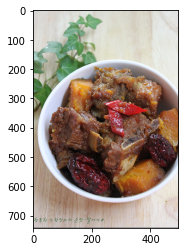

In [11]:
show_random_image_in_train_set("갈비찜")

# Data augmentation

이미지 분류에서 Overfitting을 막기 위한 방법으로, 모델에 넣을 때 이미지를 random하게 변형시키는 것

**`keras ImageDataGenerator`**
- `rescale` = 1./255 : 원본 그림은 0-255의 RGB 계수 - 이를 1/255로 스케일링하여 0-1범위로 변환. 이는 다른 전처리 과정에 앞서 가장 먼저 적용
- `rotation_range` : int, 무작위 회전의 각도 범위(degrees)
- `width_shift_range` : float, 수평 또는 수직으로 랜덤하게 평행 이동시키는 범위 (원본 가로, 세로 길이에 대한 비율 값)
- `height_shift_range` : float, 
- `shear_range` : float, 
- `zoom_range` : float, 무작위 줌의 범위
- `horizontal_flip` : boolean, input을 무작위로 가로로 뒤집는다.
- `fill_mode` : {"constant", "nearest", "reflect", "wrap"} , input 경계의 바깥 공간을 다음의 모드에 따라 다르게 채워진다.
  - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
  - 'nearest': aaaaaaaa|abcd|dddddddd
  - 'reflect': abcddcba|abcd|dcbaabcd
  - 'wrap': abcdabcd|abcd|abcdabcd

https://keras.io/api/preprocessing/image/

In [12]:
!pip install scipy

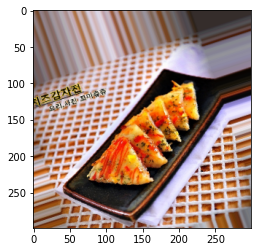

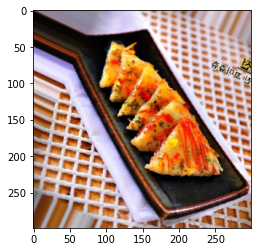

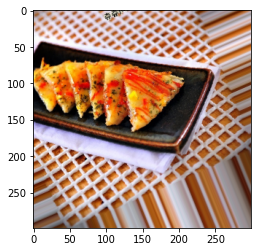

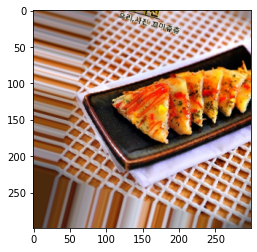

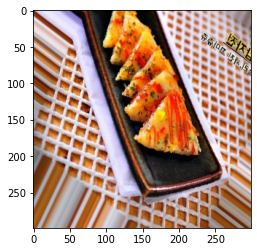

In [13]:
# 실행 시마다 parameter 범위 내에서 random하게 그림이 변형되므로 다른 변형된 그림들이 나타남

%matplotlib inline
sample_img_path = './data/train/감자전/Img_097_0000.jpg'

img = image.load_img(sample_img_path, target_size = (299, 299))

datagen = ImageDataGenerator(
    rotation_range=40,  # Int. Degree range for random rotations.
    width_shift_range=0.2, # float: fraction of total width
    height_shift_range=0.2, # float: fraction of total height
    shear_range=0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2, # Float or [lower, upper]. Range for random zoom.
    horizontal_flip=True,
    fill_mode='nearest'
)

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break # break 하지 않으면 generator 는 무한히 반복됨

plt.show()

# Generator를 사용한 이미지 전처리

* 중요) train_datagen에 대해서만 augmentation을 수행한다!

generator를 사용하지 않으면 이미지 행렬이 모두 메모리 상에 올라가기 때문에 메모리 부족 현상이 발생할 수 있지만,

<b>generator는 연산에 사용되는 부분만 메모리에 올리기 때문에 메모리 효율적이다!</b>

`flow_from_directory()` <br>
인자로 설정해주는 directory의 바로 하위 디렉토리 이름을 레이블이라 간주하고 그 레이블이라고 간주한 디렉토리 아래의 파일들을 해당 레이블의 이미지들이라고 알아서 추측하여 Numpy Array Iterator를 생성하게 된다.
- target_size : 모델에 들어갈 인풋 이미지 사이즈 중 width, height를 입력
- batch_size : 이미지 데이터 원본 소스에서 한 번에 얼마만큼의 이미지를 가져올 것인지
- class_mode : ‘categorical’, ‘sparse’, ‘binary’

++ 'flow_from_dataframe()`도 존재 - pandas dataframe으로 저장

In [44]:
# 이미지의 각 픽셀을 255로 나눠주는 것은 필수!

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255) # 검증, 테스트 데이터는 augmentation 하면 안됨!
test_datagen = ImageDataGenerator(rescale= 1./255) 

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (299, 299),
    batch_size = 8, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (299, 299),
    batch_size = 8, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    shuffle=True,
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (299, 299),
    batch_size = 8, # gpu 연산 -> 2의 거듭제곱꼴로 맞추는 것이 좋다고 함
    seed = 42
)

Found 119920 images belonging to 150 classes.
Found 15000 images belonging to 150 classes.
Found 15593 images belonging to 150 classes.


In [45]:
# generator 출력 살펴보기
for data_batch, labels_batch in train_generator:
    print("배치 데이터 크기 : ", data_batch.shape)
    print("배치 레이블 크기 : ", labels_batch.shape)
    break

배치 데이터 크기 :  (8, 299, 299, 3)
배치 레이블 크기 :  (8, 150)


In [46]:
# generator의 길이
len(train_generator)

14990

# InceptionV3 모델을 활용한 한식 이미지 분류 CNN 모델 만들기

- imagenet parameter로 훈련되어 있는 inceptionV3 모델에서 맨 위의 층을 제거한 후, <br>
Averagepooling2D 층, flatten 층, softmax 층을 추가해 모델을 구성함

- sagemaker p3.xlarge instance 사용
(GPU : 1xV100 16GB, CPU : 8cores, RAM 61GB)

##  InceptionV3 모델 구조

<img src = "images/inceptionV3_structure.png" width=500px>

출처 : https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c

##  CNN 모델간 성능 비교
<img src = "images/comparemodels.png" width=500px>
출처 : https://keras.io/applications/

### 사용 가능한 자원(CPU/GPU) 확인

In [47]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3641748163538750114
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1408043828
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5863921632920092878
physical_device_desc: "device: 0, name: GeForce MX250, pci bus id: 0000:3a:00.0, compute capability: 6.1"
]


### 파일 저장 경로 설정

In [48]:
#모델 저장 경로 설정
from datetime import datetime
today = datetime.today()
date ='{}.{}.{}.{}h'.format(today.year, today.month, today.day, today.hour)
print(date)

MODEL_SAVE_FOLDER_PATH = './model/{}/'.format(date)

if not(os.path.isdir(MODEL_SAVE_FOLDER_PATH)):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '결과 : {epoch:02d}-{val_acc:.4f}.hdf5'
print(model_path)

2022.2.15.13h
./model/2022.2.15.13h/결과 : {epoch:02d}-{val_acc:.4f}.hdf5


## InceptionV3 모델에 image_generator 투입

- 원래 InceptionV3 층에서 마지막 층을 빼고 AveragePooling, Dropout, Flatten, Dropout, softmax 층을 추가! 

`glorot_uniform` : Glorot 균등분포 초기값 설정기, Xavier 균등분포 초기값 설정기라고도 한다.

In [49]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [59]:
import tensorflow.keras.backend as K
# import tensorflow.keras.backend.tensorflow_backend as K
K.clear_session()
with tf.device('/device:GPU:0'): # gpu 사용
    # create the base pre-trained model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))

    x = base_model.output
    x = AveragePooling2D(pool_size=(8, 8))(x)
    x = Dropout(.4)(x)
    x = Flatten()(x)
    x = Dropout(.4)(x)
    predictions = Dense(150, kernel_initializer='glorot_uniform', 
                        kernel_regularizer=l2(.0005), activation='softmax')(x)
    
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    print(model)
    opt = SGD(lr=.01, momentum=.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10) # 조기종료 콜백함수 정의
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_acc', verbose=1, save_best_only=True) # 체크포인트 저장


In [60]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [61]:
# lr_scheduler : epoch 증가함에 따라 learning_rate를 작게 해 cosf_function이 최적값 주변에서 맴도는 것을 완화!

def schedule(epoch):
    if epoch < 15:
        return .01
    elif epoch < 28:
        return .002
    else:
        return .0004
lr_scheduler = LearningRateScheduler(schedule)

https://stackoverflow.com/questions/56447556/typeerror-cant-pickle-thread-lock-objects-when-training-keras-model

In [62]:
history2 = model.fit_generator(train_generator,
                        epochs=10, steps_per_epoch= len(train_generator), 
                        validation_data = val_generator,
                        validation_steps= len(val_generator),
                        use_multiprocessing=False,
                        callbacks=[cb_checkpoint, early_stopping, lr_scheduler]
                    )

Epoch 1/10
  574/14990 [>.............................] - ETA: 8:20:21 - batch: 286.5000 - size: 8.0000 - loss: 5.2264 - accuracy: 0.0070

In [ ]:
# train_acc
print("train_acc ===", history2.history['acc'])

In [ ]:
# val_acc
print("val_acc ===", history2.history['val_acc'])

## epoch에 따른 Training, validation loss, accuracy 그래프 